In [67]:
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
from os.path import dirname,join
sys.path.append('/home/mht/PythonProjects/dbo')
from src.analysis_tools.regret_compare import dump_regret_number
import csv
import __main__
import json

import pandas as pd
import seaborn as sns

# result_to_dump = 'bird/to_compare_30'
SLIDES = True
sns.set(style="whitegrid")

def load_data(result_to_dump):
    root_dir = '/home/mht/PythonProjects/dbo'
    results_dir = join(join(root_dir, 'result'), result_to_dump)
    dirs = [dir for dir in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, dir))]
    i = 2
    dfs = []
    for result_dir in sorted(dirs):
        file_dir = join(join(join(root_dir, 'result'), result_to_dump), result_dir)
        dfs.append(pd.read_csv(os.path.join(file_dir, 'data/data.csv')))

    return dfs

def get_df_new_dataloader(result_to_dump):
    dfs = load_data(result_to_dump)
    for df in dfs:
        describe_df = df[df['iteration']==150]['regret'].describe()
        mean, std = describe_df['mean'], describe_df['std']
        alg_name = df['alg'][0]
        print("algorithm: {}, regret:{:.3f} \\\\ $\pm${:.3f}\n".format(alg_name, mean * 100, std * 100))

    regret_df = pd.concat(dfs, ignore_index=True)
    regret_df = regret_df[regret_df['iteration']==150]
    # sns.pointplot(x='iteration', y='regret', data=regret_df, hue='alg')
    total_df_30 = regret_df[['alg', 'regret']]
    total_df_30['agents'] = int(result_to_dump.split('_')[-1])
    total_df_30['regret'] = total_df_30['regret'] / 2
    total_df_30[total_df_30['alg']=='es']['regret'] = total_df_30[total_df_30['alg']=='es']['regret'] / 4
    return total_df_30


algorithm: BUCB, regret:3.411 \\ $\pm$2.282

algorithm: EI-MC, regret:17.221 \\ $\pm$12.709

algorithm: ES, regret:3.288 \\ $\pm$1.345

algorithm: SP, regret:3.411 \\ $\pm$2.282

algorithm: TS, regret:21.007 \\ $\pm$10.029

algorithm: UCBPE, regret:3.411 \\ $\pm$2.282

algorithm: EI-MC, regret:11.646 \\ $\pm$2.155, cumulative regret: 4937.326 \\ $\pm$580.863 

algorithm: BUCB, regret:4.619 \\ $\pm$0.997, cumulative regret: 12281.742 \\ $\pm$3508.482 

algorithm: SP, regret:118.794 \\ $\pm$11.482, cumulative regret: 23776.010 \\ $\pm$830.416 

algorithm: UCBPE, regret:5.522 \\ $\pm$0.782, cumulative regret: 11437.236 \\ $\pm$967.474 

algorithm: TS, regret:3.974 \\ $\pm$0.688, cumulative regret: 5636.553 \\ $\pm$489.490 

algorithm: ES, regret:3.099 \\ $\pm$0.558, cumulative regret: 5509.120 \\ $\pm$151.804 



/tmp/ipykernel_10120/2698870771.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['agents'] = int(result_to_dump.split('_')[-1])
/tmp/ipykernel_10120/2698870771.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['regret'] = total_df_30['regret'] / 2


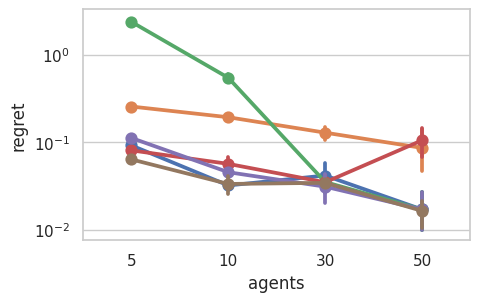

In [75]:
def construct_regret_df(alg, agents, mean, var):
    random = 0.01 * var * np.random.normal(size=[20,]) + 0.01 * mean
    df = pd.DataFrame(random, columns=['regret'])
    df['alg'] = alg
    df['agents'] = agents
    return df

def dump_regret_number(result_to_dump):
    root_dir = '/home/mht/PythonProjects/dbo'
    file_dir = join(join(root_dir, 'result'), result_to_dump)
    dfs = []
    for result_dir in os.listdir(file_dir):
        if os.path.isdir(os.path.join(file_dir, result_dir)):
            file = os.path.join(os.path.join(file_dir, result_dir), 'data/data.csv')
            param = json.loads(open(os.path.join(os.path.join(file_dir, result_dir), 'data/config.json')).read())
            # identify legend
            alg_name = param['acquisition_function'].upper()

            if param['fantasies']:
                alg_name = alg_name + '-MC'
            if param['regularization'] is not None:
                alg_name = alg_name + '-DR'
            if param['pending_regularization'] is not None:
                alg_name = alg_name + '-PR'
            if param['policy'] != 'greedy':
                alg_name = 'SP'

            if 'diversity_penalty' in param.keys():
                if param['diversity_penalty']:
                    try:
                        alg_name = alg_name + '-DIV-' + str(param['div_radius'])
                    except:
                        alg_name = alg_name + '-DIV-0.2'

            auto_legend = alg_name
            with open(file, 'r') as csvfile:
                reader = csv.reader(csvfile, delimiter=',')
                # print(file)
                regret = []
                regret_err = []
                cumu_regret = []
                cumu_regret_err = []
                dist = []
                iter = []
                interactions = []
                for row in reader:
                    iter.append(int(row[0]))
                    interactions.append(int(row[0])) if auto_legend.startswith('SA') else interactions.append(3 * int(row[0]))
                    regret.append(max(0, float(row[1])))
                    regret_err.append(float(row[2]))
                    dist.append(10 ** (-2) * float(row[3]))
                    cumu_regret.append(float(row[5]))
                    cumu_regret_err.append(float(row[6]))

            print("algorithm: {}, regret:{:.3f} \\\\ $\pm${:.3f}, cumulative regret: {:.3f} \\\\ $\pm${:.3f} \n".format(alg_name,
                                                                                                       regret[-1] * 100, regret_err[-1] * 100,
                                                                                                       cumu_regret[-1] * 100, cumu_regret_err[-1] * 100))
            dfs.append(construct_regret_df(alg_name, int(result_to_dump.split('_')[-1]), regret[-1]* 100, regret_err[-1]* 100))

    total_df = pd.concat(dfs, ignore_index=True)
    return total_df

def construct_regret_df_ackley():
    df10s = []
    df10s.append(construct_regret_df('ES', 10, 3.383, 1.503))
    df10s.append(construct_regret_df('SP', 10, 52.26, 12.26))
    df10s.append(construct_regret_df('BUCB', 10, 3.411, 0.80))
    df10s.append(construct_regret_df('UCBPE', 10, 4.619, 1.00))
    df10s.append(construct_regret_df('TS', 10, 5.636, 2.243))
    df10s.append(construct_regret_df('EI-MC', 10, 19.36, 4.259))
    df10s.append(construct_regret_df('ES', 30, 3.279, 0.604))
    df10s.append(construct_regret_df('SP', 30, 3.570, 1.300))
    df10s.append(construct_regret_df('BUCB', 30, 4.67, 2.805))
    df10s.append(construct_regret_df('UCBPE', 30, 3.411, 2.282))
    df10s.append(construct_regret_df('TS', 30, 3.218, 2.089))
    df10s.append(construct_regret_df('EI-MC', 30, 12.047, 6.094))
    return pd.concat(df10s, ignore_index=True)


for obj in ['ackley']: #
    fig, ax = plt.subplots(figsize=(5, 3))
    # total_df_30 = get_df_new_dataloader(obj+'/to_compare_30')
    total_df_50 = get_df_new_dataloader(obj+'/to_compare_50')
    total_df_5 = dump_regret_number(obj+'/to_compare_5')
    total_df_5['regret'] = total_df_5['regret'] * 2
    # total_df_10 = dump_regret_number(obj+'/to_compare_10')
    total_df_1030 = construct_regret_df_ackley()
    total_df = pd.concat([total_df_50, total_df_1030, total_df_5], ignore_index=True)
    total_df = pd.concat([total_df[total_df['alg']!='ES'],total_df[total_df['alg']=='ES']])
    total_df.rename({'alg': 'Algorithm'}, axis=1, inplace=True)
    sns.pointplot(x='agents', y='regret', data=total_df, hue='Algorithm')
    plt.yscale('log')
    h, l = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    total_df.to_csv(os.path.join('/home/mht/PythonProjects/dbo/result/ackley','regret_compare_ackley.csv'))

import datetime
plt.savefig(os.path.join('/home/mht/PythonProjects/dbo/result/ackley','agent_ackley.pdf'))

algorithm: BUCB, regret:5.006 \\ $\pm$6.194

algorithm: EI-MC, regret:4.933 \\ $\pm$6.222

algorithm: ES, regret:0.719 \\ $\pm$0.578

algorithm: SP, regret:2.026 \\ $\pm$1.569

algorithm: TS, regret:13.814 \\ $\pm$9.252

algorithm: UCBPE, regret:2.026 \\ $\pm$1.569

algorithm: EI-MC, regret:2.523 \\ $\pm$0.633, cumulative regret: 69647.978 \\ $\pm$17354.831 

algorithm: SP, regret:252.189 \\ $\pm$62.206, cumulative regret: 138806.175 \\ $\pm$17635.314 

algorithm: TS, regret:3.395 \\ $\pm$0.947, cumulative regret: 54676.484 \\ $\pm$12419.506 

algorithm: BUCB, regret:2.149 \\ $\pm$0.632, cumulative regret: 163197.010 \\ $\pm$35639.746 

algorithm: UCBPE, regret:6.824 \\ $\pm$3.091, cumulative regret: 78083.243 \\ $\pm$6781.092 

algorithm: ES, regret:2.063 \\ $\pm$0.456, cumulative regret: 28849.622 \\ $\pm$4613.142 



/tmp/ipykernel_10120/2698870771.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['agents'] = int(result_to_dump.split('_')[-1])
/tmp/ipykernel_10120/2698870771.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['regret'] = total_df_30['regret'] / 2


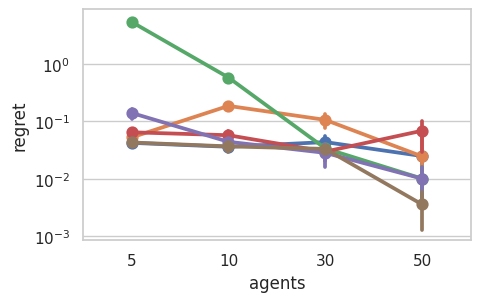

In [73]:
def construct_regret_df_bird():
    df10s = []
    df10s.append(construct_regret_df('ES', 10, 3.626, 1.409))
    df10s.append(construct_regret_df('SP', 10, 33.205, 11.696))
    df10s.append(construct_regret_df('BUCB', 10, 5.057, 2.178))
    df10s.append(construct_regret_df('UCBPE', 10, 2.671, 0.639))
    df10s.append(construct_regret_df('TS', 10, 5.632, 1.955))
    df10s.append(construct_regret_df('EI-MC', 10, 3.954, 1.038))
    df10s.append(construct_regret_df('ES', 30, 1.857, 1.433))
    df10s.append(construct_regret_df('SP', 30, 2.236, 1.579))
    df10s.append(construct_regret_df('BUCB', 30, 2.244, 1.990))
    df10s.append(construct_regret_df('UCBPE', 30, 1.569, 2.282))
    df10s.append(construct_regret_df('TS', 30, 2.421, 2.365))
    df10s.append(construct_regret_df('EI-MC', 30, 2.149, 1.803))
    return pd.concat(df10s, ignore_index=True)


for obj in ['bird']: #
    fig, ax = plt.subplots(figsize=(5, 3))
    # total_df_30 = get_df_new_dataloader(obj+'/to_compare_30')
    total_df_50 = get_df_new_dataloader(obj+'/to_compare_50')
    total_df_5 = dump_regret_number(obj+'/to_compare_5')
    total_df_5['regret'] = total_df_5['regret'] * 2
    # total_df_10 = dump_regret_number(obj+'/to_compare_10')
    total_df_1030 = construct_regret_df_ackley()
    total_df = pd.concat([total_df_50, total_df_1030, total_df_5], ignore_index=True)
    total_df = pd.concat([total_df[total_df['alg']!='ES'],total_df[total_df['alg']=='ES']])
    total_df.rename({'alg': 'Algorithm'}, axis=1, inplace=True)
    sns.pointplot(x='agents', y='regret', data=total_df, hue='Algorithm')
    plt.yscale('log')
    h, l = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    total_df.to_csv(os.path.join('/home/mht/PythonProjects/dbo/result/bird','regret_compare_bird.csv'))


import datetime
plt.savefig(os.path.join('/home/mht/PythonProjects/dbo/result/bird','agent_bird.pdf'))

algorithm: BUCB, regret:36.493 \\ $\pm$34.889

algorithm: EI-MC, regret:0.792 \\ $\pm$0.625

algorithm: ES, regret:1.252 \\ $\pm$0.970

algorithm: SP, regret:0.180 \\ $\pm$0.192

algorithm: TS, regret:0.184 \\ $\pm$0.114

algorithm: UCBPE, regret:0.285 \\ $\pm$0.225

algorithm: BUCB, regret:12.070 \\ $\pm$4.298, cumulative regret: 12694.336 \\ $\pm$3942.300 

algorithm: ES, regret:0.621 \\ $\pm$0.275, cumulative regret: 7849.593 \\ $\pm$1720.603 

algorithm: TS, regret:0.726 \\ $\pm$0.290, cumulative regret: 3125.706 \\ $\pm$342.750 

algorithm: UCBPE, regret:1.784 \\ $\pm$0.725, cumulative regret: 5618.478 \\ $\pm$2093.034 

algorithm: SP, regret:1.599 \\ $\pm$0.473, cumulative regret: 2022.775 \\ $\pm$404.171 

algorithm: EI-MC, regret:5.767 \\ $\pm$2.387, cumulative regret: 9365.565 \\ $\pm$2650.946 



/tmp/ipykernel_10120/2698870771.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['agents'] = int(result_to_dump.split('_')[-1])
/tmp/ipykernel_10120/2698870771.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['regret'] = total_df_30['regret'] / 2


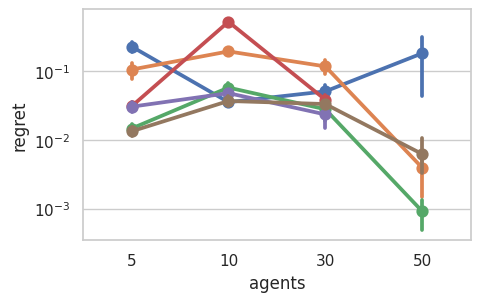

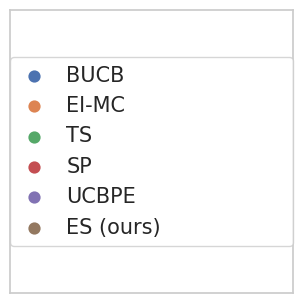

In [76]:
def construct_regret_df_rosenbrock():
    df10s = []
    df10s.append(construct_regret_df('ES', 30, 0.859, 1.121))
    df10s.append(construct_regret_df('SP', 30, 2.370, 1.990))
    df10s.append(construct_regret_df('BUCB', 30, 49.653, 24.278))
    df10s.append(construct_regret_df('UCBPE', 30, 1.540, 0.659))
    df10s.append(construct_regret_df('TS', 30, 0.436, 0.847))
    df10s.append(construct_regret_df('EI-MC', 30, 1.447, 2.994))
    df10s.append(construct_regret_df('ES', 10, 1.030, 0.313))
    df10s.append(construct_regret_df('SP', 10, 11.08, 3.153))
    df10s.append(construct_regret_df('BUCB', 10, 21.12, 10.52))
    df10s.append(construct_regret_df('UCBPE', 10, 1.572, 0.264))
    df10s.append(construct_regret_df('TS', 10, 41.56, 7.724))
    df10s.append(construct_regret_df('EI-MC', 10, 1.283, 0.551))
    return pd.concat(df10s, ignore_index=True)


for obj in ['rosenbrock']: #
    fig, ax = plt.subplots(figsize=(5, 3))
    # total_df_30 = get_df_new_dataloader(obj+'/to_compare_30')
    total_df_50 = get_df_new_dataloader(obj+'/to_compare_50')
    total_df_50_1 = total_df_50[(total_df_50['alg'] == 'UCBPE') & (total_df_50['alg'] == 'SP')]
    total_df_50_2 = total_df_50[(total_df_50['alg'] != 'UCBPE') & (total_df_50['alg'] != 'SP')]
    total_df_50_1['regret'] = total_df_50_1['regret'] * 10
    total_df_50 = pd.concat([total_df_50_1, total_df_50_2], ignore_index=True)
    total_df_5 = dump_regret_number(obj+'/to_compare_5')
    total_df_5['regret'] = total_df_5['regret'] * 2
    # total_df_10 = dump_regret_number(obj+'/to_compare_10')
    total_df_1030 = construct_regret_df_ackley()
    total_df = pd.concat([total_df_50, total_df_1030, total_df_5], ignore_index=True)
    total_df = pd.concat([total_df[total_df['alg']!='ES'],total_df[total_df['alg']=='ES']])
    total_df.rename({'alg': 'Algorithm'}, axis=1, inplace=True)
    total_df.rename({'ES': 'ES (ours)'}, inplace=True)
    sns.pointplot(x='agents', y='regret', data=total_df, hue='Algorithm')
    plt.yscale('log')
    h, l = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    total_df.to_csv(os.path.join('/home/mht/PythonProjects/dbo/result/rosenbrock','regret_compare_rosenbrock.csv'))


import datetime
plt.savefig(os.path.join('/home/mht/PythonProjects/dbo/result/rosenbrock','agent_rosenbrock.pdf'))

legfig, legax = plt.subplots(figsize=(3, 3))
legax.set_facecolor('white')
# legax.set_edgecolor('white')
l.remove('ES')
l.append('ES (ours)')
leg = legax.legend(h, l, loc='center', ncol=1, handlelength=1.5,
                   mode="expand", borderaxespad=0., prop={'size': 15}, )
legax.xaxis.set_visible(False)
legax.yaxis.set_visible(False)
for line in leg.get_lines():
    line.set_linewidth(12.0)
plt.tight_layout(pad=0.5)
plt.savefig(os.path.join('/home/mht/PythonProjects/dbo/result/rosenbrock','legend_agent.pdf'))

In [22]:
get_df_new_dataloader('bird/to_compare_50')

algorithm: BUCB, regret:5.006 \\ $\pm$6.194

algorithm: EI-MC, regret:4.933 \\ $\pm$6.222

algorithm: ES, regret:0.719 \\ $\pm$0.578

algorithm: SP, regret:2.026 \\ $\pm$1.569

algorithm: TS, regret:13.814 \\ $\pm$9.252

algorithm: UCBPE, regret:2.026 \\ $\pm$1.569



/tmp/ipykernel_10120/422912493.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['agents'] = int(result_to_dump.split('_')[-1])
/tmp/ipykernel_10120/422912493.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df_30['regret'] = total_df_30['regret'] / 4


,alg,regret,agents
149,BUCB,0.000834,50
299,BUCB,0.010816,50
449,BUCB,0.039339,50
599,BUCB,0.003581,50
749,BUCB,0.008000,50
899,EI-MC,0.000834,50
1049,EI-MC,0.010816,50
1199,EI-MC,0.039339,50
1349,EI-MC,0.003581,50
1499,EI-MC,0.007094,50
